### Roadmap for this notebook:

#### A) Discrete Mountaincar, to directly compare to DQN on this benchmark.

1. A basic actor-critic, with the appropriate losses.
2. A parallised version, in threading mode. Reqs accumulating losses, and the threading version.
3. A multiprocessing version, where the workers work in parallel. Reqs communicating variables across memory spaces.
4. Entropy loss.
5. Normalization of losses, etc.?
6. Joint basic network for actions and values? Use additive loss?

#### B) Continuous Mountaincar

#### C) Atari?

#### D) Generalised advantage estimation?


### Questions:

1. loss values will be quite correlated, certainly wrt experience replay. How does this affect the algorithm?
2. How would DQN perform vs this if experience replay doesn't happen every step?

# A1) AC implementation on the discrete Mountain Car

We'll do an implementation with separate value and policy networks.

In [13]:
import numpy as np
import random
import gym
import time
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import models 
from keras import layers
import keras.backend as kb
from matplotlib import pyplot as plt
from matplotlib import colors as c
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

Using TensorFlow backend.
C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tenso

In [31]:
def actor_loss(y_actual, y_pred):
    """
    My guess: y_pred is pi(a|s),
              y_actual will be (G_estim - V(S_t)) * 1_{a = A_t}
    We want: - log(pi(A_t|s)) (G_estim - V(S_t)), note that we only select one action.
    """
    return - kb.log(y_pred + 1e-10) * kb.stop_gradient(y_actual) # This is automatically cast to a scalar?

class ACAgent_discrete():
    
    def __init__(self, env, track_V = False, learning_rate = 0.001):
        
        # Hyperparameters for the algorithm:
        self.epsilon = .9       # Exploration rate. 
        self.epsilon_decay = .95 # Decay of the exploration rate, multiplied with epsilon every training episode.
        self.epsilon_min = .1                   # Minimal exploration rate.
        self.lr = learning_rate                 # Learning Rate.
        self.gamma = .99                        # The discounting factor of the Markov Decision Process.
    
        # Environment specification:
        self.env = env
        self.num_actions = env.action_space.n
        self.num_state_dim = env.observation_space.shape[0]
        
        # Q-Network and Policy Network specifications - 2 hidden layers with relu followed by, for the
        #                                               Value network ("The Critic"): a linear layer
        #                                               Policy Network ("The Actor"): a softmax layer
        self.num_nodes_layer1 = 24          # The number of nodes in the first hidden layer of the network.
        self.num_nodes_layer2 = 48          # The number of nodes in the second hidden layer of the network.
        self.critic = self.init_critic()
        self.target_critic = self.init_critic() # Fixed targets for the network updates.
        self.target_critic.set_weights(self.critic.get_weights())
        self.actor = self.init_actor()
         
        # Metrics to evaluate the agent - TODO
        self.training_epis = 0              # Number of training iterations so far.
        self.num_steps = []                 # Number of time steps needed to complete the episode, for each episode.
        self.values = []                    # Total reward acrued for every episode.
        self.max_X_list = []                # A list keeping track of the maximal x position in every training episode.
        self.track_V = track_V              # A boolean indicating whether the agent keeps track of the V-values at 2 states over all episodes.
        self.xstart_vpos = []               # List of V-estimates in x = -0.5 (start position) and v = 0.01 over the training iterations.
        self.xstart_vneg = []               # List of V-estimates in x = -0.5 (start position) and v = -0.01 over the training iterations.

        
    def init_critic(self):
        model = Sequential()
        model.add(Dense(units = self.num_nodes_layer1, activation = 'relu', input_dim = self.num_state_dim))
        model.add(Dense(units = self.num_nodes_layer2, activation = 'relu'))
        model.add(Dense(1, activation = 'linear'))
        model.compile(loss = 'mse', 
                      optimizer = Adam(lr = self.lr))
        return model
    
    def init_actor(self):
        model = Sequential()
        model.add(Dense(units = self.num_nodes_layer1, activation = 'relu', input_dim = self.num_state_dim))
        model.add(Dense(units = self.num_nodes_layer2, activation = 'relu'))
        model.add(Dense(self.num_actions, activation = 'softmax'))
        model.compile(loss = actor_loss, 
                      optimizer = Adam(lr = self.lr))
        return model
    
#     def learn_test(self, state, verbose = False):
#         """
#         State needs to be of shape [1, state_dim]
#         """
#         p = self.actor.predict(state)[0]
#         action = np.random.choice(self.num_actions, p = self.actor.predict(state)[0])
#         next_state, reward, done, _ = self.env.step(action)
#         next_state = np.reshape(next_state, [1, self.num_state_dim])
        
#         target = self.critic.predict(state)
#         next_state_target = self.target_critic.predict(next_state)
#         TD = np.array([0. for i in range(self.num_actions)]).reshape([1, self.num_actions])
#         if verbose:
#             print(f"Initial Critic estimate for the initial state: {target}")
#             print(f"Initial Actor estimate: {p}")

#         if done:
#             TD[0,action] = reward - target[0]
#             target[0] = reward
#         else:
#             TD[0,action] = reward + self.gamma * next_state_target[0] - target[0] # Change to Sarsa?
#             target[0] = reward + self.gamma * next_state_target[0]
            
#         self.critic.fit(state, target, epochs = 1, verbose = 0) # keras requires multidimensional targets. The ones corresponding to the actions not taken cancel out.
#         self.actor.fit(state, TD, epochs = 1, verbose = 0)
#         if verbose:
#             print(f"After learning: Critic estimate at initial state: {self.critic.predict(state)}, target: {target}, action: {action}.")
#             print(f"TD: {TD}, updated actor estimate: {self.actor.predict(state)}.")
#             print("Note that if TD is positive, then the optimization objective should increase the chance of the action chosen. And vice versa.")
        
#         return reward, next_state, done
        
#     def test(self):
#         state = np.reshape(env.reset(), [1, self.num_state_dim])
#         self.learn_test(state)
        
    def learn(self, state, action, reward, next_state, done, verbose = False):
        # Maybe more efficient if not copying all these variables? But perhaps negligible wrt computations inside. 
        
        target = self.critic.predict(state)
        next_state_target = self.target_critic.predict(next_state)
        TD = np.array([0. for i in range(self.num_actions)]).reshape([1, self.num_actions])
        if verbose:
            print(f"Initial Critic estimate for the initial state: {target}")
            print(f"Initial Actor estimate: {p}")

        if done:
            TD[0,action] = reward - target[0]
            target[0] = reward
        else:
            TD[0,action] = reward + self.gamma * next_state_target[0] - target[0] # Change to Sarsa?
            target[0] = reward + self.gamma * next_state_target[0]
            
        self.critic.fit(state, target, epochs = 1, verbose = 0) # keras requires multidimensional targets. The ones corresponding to the actions not taken cancel out.
        self.actor.fit(state, TD, epochs = 1, verbose = 0)
        if verbose:
            print(f"After learning: Critic estimate at initial state: {self.critic.predict(state)}, target: {target}, action: {action}.")
            print(f"TD: {TD}, updated actor estimate: {self.actor.predict(state)}.")
            print("Note that if TD is positive, then the optimization objective should increase the chance of the action chosen. And vice versa.")
        
        
    def learn_mepis(self, num_epis, verbose = True):
        
        end_it = self.training_epis + num_epis # The total amount of episodes the agent will have trained on after this function finishes.
    
        for epis in range(num_epis):
            epis_time = time.time()
            state = np.reshape(self.env.reset(), [1, self.num_state_dim])
            self.values.append(0)
            max_X = state[0,0]
            for t in range(201):
                
                # Sample action:
                action = np.random.choice(self.num_actions, p = self.actor.predict(state)[0])
                
                # Sample environment:
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.num_state_dim])
                
                # Update actor and critic:
                self.learn(state, action, reward, next_state, done)
                state = next_state
                                
                # Updates for some of the evaluation metrics:
                self.values[-1] += (self.gamma ** t) * reward
                if state[0,0] > max_X:
                    max_X = state[0,0]
                    
                if done:
                    self.num_steps.append(t+1)
                    self.max_X_list.append(max_X)
                    break
                    
            self.target_critic.set_weights(self.critic.get_weights())
            
            # Updates for some of the evaluation metrics:
            self.training_epis += 1
            if self.track_V:
                self.track_V_fct()
                
            # Some diagnostic information to be printed:
            if verbose:
                print(f"\r{self.training_epis}/{end_it} episodes. Episode time: {time.time() - epis_time}. Max x: {max_X}, t = {self.num_steps[-1]}.", end = '')
            
            # Update the exploration rate:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                
    def track_V_fct(self):
        """
        Track the V values over the different episodes at [-0.5, 0.01] and [-0.5, -0.01].
        """
        self.xstart_vpos.append( self.critic.predict(np.array([-0.5, 0.01]).reshape([1,2])))
        self.xstart_vneg.append( self.critic.predict(np.array([-0.5, -0.01]).reshape([1,2])))
        
    def plot_max_X(self, start_it = 0):
        """
        Plots the maximal x-value that was attained during the different training episodes.
        """
        fig = plt.figure()
        grid = np.arange(start_it, self.training_epis)
        plt.plot(grid, self.max_X_list[start_it:])
        plt.title("Maximum x-value reached per episode")
        plt.show()
        
    def plot_num_steps(self, start_it = 0):
        """
        Plots the number of steps needed to complete the episodes during the different training episodes.
        """
        fig = plt.figure()
        grid = np.arange(start_it, self.training_epis)
        plt.plot(grid, self.num_steps[start_it:])
        plt.title("Number of steps needed to complete the episode (max = 200)")
        plt.show()



In [32]:
env = gym.make('MountainCar-v0')
agent = ACAgent_discrete(env, track_V = True)

In [35]:
agent.learn_mepis(1000)

1020/1020 episodes. Episode time: 0.9160935878753662. Max x: -0.1499382767519785, t = 200..

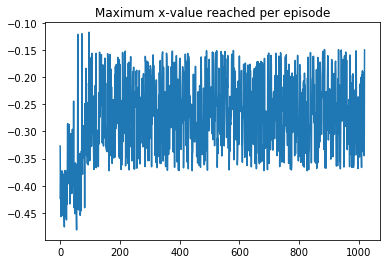

In [36]:
agent.plot_max_X()

`threading` versus `multiprocessing`?

[link](https://realpython.com/intro-to-python-threading/)

# A2) Threading version of A3C on Discrete Mountaincar

This part will restructure some code of the previous section, by splitting it into:
1. A class AC_Network that builds an Actor-Critic model.
2. Worker classes that will instantiate local AC-models, create rollouts of the environment, and apply learning to the global network.

We will implement a synchronous version here. See [awjuliani's Vizdoom example](https://github.com/awjuliani/DeepRL-Agents) for a neat implementation where communication of the variables happens in tensorflow. We might do something similar here with communication through other variables.

In [123]:
import threading

In [172]:
def actor_loss(y_actual, y_pred):
    """
    My guess: y_pred is pi(a|s),
              y_actual will be (G_estim - V(S_t)) * 1_{a = A_t}
    We want: - log(pi(A_t|s)) (G_estim - V(S_t)), note that we only select one action.
    """
    return - kb.log(y_pred + 1e-10) * kb.stop_gradient(y_actual) # This is automatically cast to a scalar?

class AC_Network():
    def __init__(self, num_state_dim ,num_actions, lr = 0.001):
        self.num_state_dim = num_state_dim  # The dimension of the state space.
        self.num_actions = num_actions      # The number of actions.
        self.lr = lr                        # The learning rate of the network optimiser
        
        # Q-Network and Policy Network specifications - 2 hidden layers with relu followed by, for the
        #                                               Value network ("The Critic"): a linear layer
        #                                               Policy Network ("The Actor"): a softmax layer
        # Note: At the moment, we do not keep track of a separate Target Network. 
        #       As updates are only applied every couple of steps, it is kept fixed for the duration in between.
        self.num_nodes_layer1 = 24          # The number of nodes in the first hidden layer of the network.
        self.num_nodes_layer2 = 48          # The number of nodes in the second hidden layer of the network.
        self.critic = self.init_critic()
        self.actor = self.init_actor()
    
    def init_critic(self):
        model = Sequential()
        model.add(Dense(units = self.num_nodes_layer1, activation = 'relu', input_dim = self.num_state_dim))
        model.add(Dense(units = self.num_nodes_layer2, activation = 'relu'))
        model.add(Dense(1, activation = 'linear'))
        model.compile(loss = 'mse', 
                      optimizer = Adam(lr = self.lr))
        return model
    
    def init_actor(self):
        model = Sequential()
        model.add(Dense(units = self.num_nodes_layer1, activation = 'relu', input_dim = self.num_state_dim))
        model.add(Dense(units = self.num_nodes_layer2, activation = 'relu'))
        model.add(Dense(self.num_actions, activation = 'softmax'))
        model.compile(loss = actor_loss, 
                      optimizer = Adam(lr = self.lr))
        return model

In [198]:
class Worker():
    
    def __init__(self, env, worker_name, epsilon = .95, epsilon_decay = .95, learning_rate = .001, t_update = 31, track_V = False):
        # Hyperparameters for the algorithm:
        self.epsilon = epsilon                  # Exploration rate. 
        self.epsilon_decay = epsilon_decay      # Decay of the exploration rate, multiplied with epsilon every training episode.
        self.epsilon_min = .1                   # Minimal exploration rate.
        self.lr = learning_rate                 # Learning Rate.
        self.gamma = .99                        # The discounting factor of the Markov Decision Process
        self.t_update = t_update                # Number of steps before updating the global network
        
        # Environment specification:
        self.env = env
        self.num_state_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.current_state = env.reset()[np.newaxis, :]
        
        # Actor and Critic models:
        self.network = AC_Network(self.num_state_dim, self.num_actions, self.lr)
        
        # Some trackers:
        self.name = worker_name
        self.num_steps = 0                  # Total number of timesteps taken.
        self.num_steps_to_completion = []   # Number of time steps needed to complete the episode, for each episode.
        self.max_X_list = []                # A list keeping track of the maximal x position in every training episode.

        # TODO - to implement
        self.values = []                    # Total reward acrued for every episode.
        self.track_V = track_V              # A boolean indicating whether the agent keeps track of the V-values at 2 states over all episodes.
        self.xstart_vpos = []               # List of V-estimates in x = -0.5 (start position) and v = 0.01 over the training iterations.
        self.xstart_vneg = []               # List of V-estimates in x = -0.5 (start position) and v = -0.01 over the training iterations.

    def update_network_weights(self, critic_weights, actor_weights):
        self.network.critic.set_weights(critic_weights)
        self.network.actor.set_weights(actor_weights)
        # TODO: update target weights.
        
                  
    def work_one_update(self, lock, total_num_steps): 
        # Could do a synchronous version with threading.Event(), and the wait(), set() and clear() calls
        global critic_weights
        global actor_weights
        global global_num_steps # Number of steps taken by all agents together.
        
        while global_num_steps < total_num_steps :
            local_critic_weights = [] # Take a copy of the weights. Could be avoided if at every update loop, the threads wait for each other.
            for layer in critic_weights:
                local_critic_weights.append(np.copy(layer))
            local_actor_weights = []
            for layer in actor_weights:
                local_actor_weights.append(np.copy(layer))

            # Network weight updates  
            self.network.critic.set_weights(local_critic_weights)
            self.network.actor.set_weights(local_actor_weights)    

            state = self.current_state
            rollout = {'states':[], 'actions': [], 'rewards': [], 'done': []} # The [states], [actions], [rewards], [values] [done] before a network update gets performed.
            rollout['states'].append(state)

            ## 0-Rollout prep
            # Sample action:
            action = np.random.choice(self.num_actions, p = self.network.actor.predict(state)[0])

            # Sample environment:
            next_state, reward, done, _ = self.env.step(action)
            next_state = np.reshape(next_state, [1, self.num_state_dim])

            rollout['states'].append(next_state)
            rollout['actions'].append(action)
            rollout['rewards'].append(reward)
            rollout['done'].append(done)

            state = next_state
            self.num_steps += 1
            t = 1

            ## 1-Rollout
            while not done and (t % self.t_update != 0):           
                # Sample action:
                action = np.random.choice(self.num_actions, p = self.network.actor.predict(state)[0])

                # Sample environment:
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.num_state_dim])

                rollout['states'].append(next_state)
                rollout['actions'].append(action)
                rollout['rewards'].append(reward)
                rollout['done'].append(done)

                state = next_state

                # TODO - Compute number of steps per episode, max_X
                self.num_steps += 1   
                t += 1
            rollout['states'] = np.array(rollout['states']).reshape([t + 1, self.num_state_dim])

            ## 2-Discounted value computation, and the advantages computation 
            # Value computation:
            values = np.zeros([t + 1, 1])
            if not done: 
                values[-1, 0] = self.network.critic.predict(state)[0]
                # if done, then we keep 0. at the end
            for s in range(t):
                values[-s - 2, 0] = rollout['rewards'][-s - 1] + self.gamma * values[-s - 1, 0]
                # So now the 'values' consists of the reverse of [V_{T+1}, r_T+ y V_{T+1}, r_{T-1} + y r_T + y^2 V_{T+1}, ... ] ('t + 1' values)
            # Advantage computation - one-hot vector:
            targets = self.network.critic.predict(rollout['states'])
            advantages = np.zeros([t, self.num_actions])
            for s in range(t):
                advantages[s, rollout['actions'][s]] = values[s, 0] - targets[s, 0]

            ## 3-Local Network update, and communication of update across threads
            #print(values.shape)
            #print(rollout['states'][:-1, :].shape)
            print(advantages.shape)
            self.network.critic.fit(rollout['states'][:-1, :], values[:-1, 0], epochs = 1, verbose = 0) # keras requires multidimensional targets. The ones corresponding to the actions not taken cancel out.
            self.network.actor.fit(rollout['states'][:-1, :], advantages, epochs = 1, verbose = 0)
            
            lock.acquire()
            global_num_steps += t
            critic_weights = list(map(np.add, critic_weights, map(np.subtract, self.network.critic.get_weights(), local_critic_weights)))
            actor_weights = list(map(np.add, actor_weights, map(np.subtract, self.network.actor.get_weights(), local_actor_weights)))
            lock.release()

            ## 4-end-updates
            # Update the exploration rate and the current state if done:
            if done: 
                state = env.reset()[np.newaxis, :]
                if self.epsilon > self.epsilon_min:
                    self.epsilon *= self.epsilon_decay
            # Save the current state for the next call
            self.current_state = state

            print(f"Worker {self.name}: {self.num_steps} steps taken.")
            print(f"Global number of steps taken: {global_num_steps}.\n")
            
                    

How to see how much time is spent in every thread?

In [199]:
global_network = AC_Network(env.observation_space.shape[0], env.action_space.n, .001)

total_num_steps = 2 * 200
num_workers = 4

workers = [Worker(gym.make('MountainCar-v0'), k) for k in range(num_workers)]
lock = threading.Lock()

critic_weights = global_network.critic.get_weights()
actor_weights = global_network.actor.get_weights()
global_num_steps = 0
print(critic_weights[0])

[[-0.28670782 -0.02788925 -0.06777087 -0.18434122  0.4568603   0.28724968
   0.03795826 -0.2853105   0.27741003 -0.40931883  0.14476985  0.4072191
   0.38409442  0.0986656   0.22643048  0.45395046  0.11907417  0.37108326
   0.07703149 -0.04403457  0.25065845 -0.39026266 -0.45111462  0.11617988]
 [-0.40158388  0.34683663 -0.17689294  0.1523524  -0.34071082 -0.29508597
  -0.3764456  -0.39310125 -0.29657662 -0.2180981   0.2603336   0.2625414
  -0.47051588 -0.19247934 -0.3643302  -0.11263385 -0.23097523 -0.36659038
  -0.12580088  0.15055215  0.44710177 -0.36307183  0.17579228  0.22464961]]


In [197]:
workers[0].work_one_update(lock, 150)
print(critic_weights[0])

(31, 3)
Worker 0: 31 steps taken.
(31, 3)
Worker 0: 62 steps taken.
(31, 3)
Worker 0: 93 steps taken.
(31, 3)
Worker 0: 124 steps taken.
(31, 3)
Worker 0: 155 steps taken.
[[ 0.01274633 -0.19954547 -0.17967601 -0.42114732 -0.23606771  0.09016556
  -0.33452508  0.2317608  -0.2063304   0.17704481  0.21111733 -0.35703015
   0.32437164 -0.31940374  0.17580944 -0.31718016  0.23238915  0.43197417
  -0.11343345  0.01622331 -0.46622062 -0.26930937  0.3485648  -0.30567515]
 [ 0.07286012  0.01309029 -0.13716903 -0.19615796  0.31233343  0.4790058
   0.31744534  0.34870327 -0.30494833 -0.31263328 -0.216492    0.02939153
   0.25464398  0.26114893 -0.3883202   0.08335003  0.19051921 -0.06742144
  -0.06002437  0.13479406  0.05731096 -0.07065872  0.05481303  0.28930423]]


In [200]:
worker_threads = []

for k in range(num_workers):
    worker_threads.append(threading.Thread(target = workers[k].work_one_update, args = (lock, total_num_steps)))
    worker_threads[k].start()
for k in range(num_workers):
    worker_threads[k].join()

Exception in thread Thread-154362:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-198-5d04f1e8a4dc>", line 54, in work_one_update
    self.network.critic.set_weights(local_critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 527, in set_weights
    K.batch_set_value(tuples)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\backend\tensorflow_backend.py", line 2960, in batch_set_value
    tf_keras_backend.batch_set_value(tuples)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\backend.py", line 2875, in batch_set_value
    assign_op = x.assign(assign_placeholder)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\resource_

Old version:


In [183]:
## Old version, skip this cell.

class Worker_nonglobal():
    
    def __init__(self, env, worker_name, epsilon = .95, epsilon_decay = .95, learning_rate = .001, t_update = 31, track_V = False):
        # Hyperparameters for the algorithm:
        self.epsilon = epsilon                  # Exploration rate. 
        self.epsilon_decay = epsilon_decay      # Decay of the exploration rate, multiplied with epsilon every training episode.
        self.epsilon_min = .1                   # Minimal exploration rate.
        self.lr = learning_rate                 # Learning Rate.
        self.gamma = .99                        # The discounting factor of the Markov Decision Process
        self.t_update = t_update                # Number of steps before updating the global network
        
        # Environment specification:
        self.env = env
        self.num_state_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.current_state = env.reset().reshape([1, self.num_state_dim])
        
        # Actor and Critic models:
        self.network = AC_Network(self.num_state_dim, self.num_actions, self.lr)
        
        # Some trackers:
        self.name = worker_name
        self.num_steps = 0                  # Total number of timesteps taken.
        self.num_steps_to_completion = []   # Number of time steps needed to complete the episode, for each episode.
        self.max_X_list = []                # A list keeping track of the maximal x position in every training episode.

        # TODO - to implement
        self.values = []                    # Total reward acrued for every episode.
        self.track_V = track_V              # A boolean indicating whether the agent keeps track of the V-values at 2 states over all episodes.
        self.xstart_vpos = []               # List of V-estimates in x = -0.5 (start position) and v = 0.01 over the training iterations.
        self.xstart_vneg = []               # List of V-estimates in x = -0.5 (start position) and v = -0.01 over the training iterations.

    def update_network_weights(self, critic_weights, actor_weights):
        self.network.critic.set_weights(critic_weights)
        self.network.actor.set_weights(actor_weights)
        # TODO: update target weights.
                  
    def work_one_update(self, critic_weights, actor_weights): 
             
        # Network weight updates - TODO: experiment with global variables to minimize cost of copying this variable?   
        self.network.critic.set_weights(critic_weights)
        self.network.actor.set_weights(actor_weights)    
        
        state = self.current_state
        rollout = {'states':[], 'actions': [], 'rewards': [], 'done': []} # The [states], [actions], [rewards], [values] [done] before a network update gets performed.
        rollout['states'].append(state)
        
        ## 0-Rollout prep
        # Sample action:
        action = np.random.choice(self.num_actions, p = self.network.actor.predict(state)[0])

        # Sample environment:
        next_state, reward, done, _ = self.env.step(action)
        next_state = np.reshape(next_state, [1, self.num_state_dim])

        rollout['states'].append(next_state)
        rollout['actions'].append(action)
        rollout['rewards'].append(reward)
        rollout['done'].append(done)

        state = next_state
        self.num_steps += 1
        t = 1
        
        ## 1-Rollout
        while not done and (self.num_steps % self.t_update != 0):           
            # Sample action:
            action = np.random.choice(self.num_actions, p = self.network.actor.predict(state)[0])
                
            # Sample environment:
            next_state, reward, done, _ = self.env.step(action)
            next_state = np.reshape(next_state, [1, self.num_state_dim])
            
            rollout['states'].append(next_state)
            rollout['actions'].append(action)
            rollout['rewards'].append(reward)
            rollout['done'].append(done)
            
            state = next_state
            
            # TODO - Compute number of steps per episode, max_X
            self.num_steps += 1   
            t += 1
        rollout['states'] = np.array(rollout['states']).reshape([t + 1, self.num_state_dim])

        ## 2-Discounted value computation, and the advantages computation 
        # Value computation:
        values = np.zeros([t + 1, 1])
        if not done: 
            values[-1, 0] = self.network.critic.predict(state)[0]
            # if done, then we keep 0. at the end
        for s in range(t):
            values[-s - 2, 0] = rollout['rewards'][-s - 1] + self.gamma * values[-s - 1, 0]
            # So now the 'values' consists of the reverse of [V_{T+1}, r_T+ y V_{T+1}, r_{T-1} + y r_T + y^2 V_{T+1}, ... ] ('t + 1' values)
        # Advantage computation - one-hot vector:
        targets = self.network.critic.predict(rollout['states'])
        advantages = np.zeros([t, self.num_actions])
        for s in range(t):
            advantages[s, rollout['actions'][s]] = values[s, 0] - targets[s, 0]
        
        ## 3-Network update and copy, reset rollout, reset state
        #print(values.shape)
        #print(rollout['states'][:-1, :].shape)
        print(advantages.shape)
        self.network.critic.fit(rollout['states'][:-1, :], values[:-1, 0], epochs = 1, verbose = 0) # keras requires multidimensional targets. The ones corresponding to the actions not taken cancel out.
        self.network.actor.fit(rollout['states'][:-1, :], advantages, epochs = 1, verbose = 0)
        
        ## 4-end-updates
        # Update the exploration rate and the current state if done:
        if done: 
            state = np.reshape(env.reset(), [1, self.num_state_dim])
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            print([rollout[k] for k in rollout])
        # Save the current state for the next call
        self.current_state = state
        
        print(f"Worker {self.name}: {self.num_steps} steps taken.")
        return 
                    

In [181]:
global_network = AC_Network(env.observation_space.shape[0], env.action_space.n, .001)

total_num_steps = 2 * 200
num_workers = 4

workers = [Worker_nonglobal(gym.make('MountainCar-v0'), k) for k in range(num_workers)]

In [182]:
workers[0].work_one_update(global_network.critic.get_weights(), global_network.actor.get_weights())
workers[1].work_one_update(global_network.critic.get_weights(), global_network.actor.get_weights())
workers[2].work_one_update(global_network.critic.get_weights(), global_network.actor.get_weights())
workers[3].work_one_update(global_network.critic.get_weights(), global_network.actor.get_weights())
# Sometimes it stops before 31 or 200 timesteps?

(31, 3)
Worker 0: 31 steps taken.
(31, 3)
Worker 1: 31 steps taken.
(31, 3)
Worker 2: 31 steps taken.
(31, 3)
Worker 3: 31 steps taken.


In [179]:
num_steps = 0
worker_threads = []
critic_weights = global_network.critic.get_weights()
actor_weights = global_network.actor.get_weights()
while num_steps < total_num_steps:
    for k in range(num_workers):
        worker_threads.append(threading.Thread(target = workers[k].work_one_update, args = (critic_weights, actor_weights)))
        worker_threads[k].start()
    for k in range(num_workers):
        worker_threads[k].join()
    num_steps = sum([workers[k].num_steps for k in range(num_workers)])
    for layer in critic_weights:
        layer *= - (num_workers - 1)
    for layer in actor_weights:
        layer *= - (num_workers - 1)
    for k in range(num_workers):
        critic_weights = map(np.add, critic_weights, workers[k].network.critic.get_weights())
        actor_weights = map(np.add, actor_weights, workers[k].network.actor.get_weights())        
    print(num_steps)
    # Get the weights back and add them.
    worker_threads = []
     
global_network.critic.set_weights(critic_weights)
global_network.actor.set_weights(actor_weights)

Exception in thread Thread-143506:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 527, in set_weights
    K.batch_set_value(tuples)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\backend\tensorflow_backend.py", line 2960, in batch_set_value
    tf_keras_backend.batch_set_value(tuples)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\backend.py", line 2880, in batch_set_value
    get_session().run(assign_ops, feed_dict=feed_dict)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\client\se

124
124
124
124
124


Exception in thread Thread-143510:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143511:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-143526:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143527:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-143543:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-143545:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-143562:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143563:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-143586:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143587:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-143606:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-143607:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-143624:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143625:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-143644:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-143645:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

Exception in thread Thread-143662:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143663:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-143684:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143685:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-143706:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143707:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124



Exception in thread Thread-143723:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143724:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-143738:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143739:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-143758:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143759:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-143782:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143783:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-143805:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143806:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-143826:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143827:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-143847:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143848:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-143866:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143867:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


Exception in thread Thread-143887:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143888:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-143906:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143907:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-143922:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143923:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-143942:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143943:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124


Exception in thread Thread-143958:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-143959:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124



Exception in thread Thread-143977:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-143976:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-143994:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-143995:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-144014:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144015:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-144034:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144035:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144058:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144059:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144078:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144079:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-144098:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144099:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-144122:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144123:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144142:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144143:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-144165:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144164:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144185:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144186:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144202:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144203:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144225:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144226:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144244:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144245:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144262:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144263:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144286:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144287:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-144306:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144307:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144328:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144329:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144350:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144351:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144370:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144371:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144392:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144393:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144410:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144411:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144426:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144427:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-144442:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144443:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144458:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144459:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144478:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144479:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144498:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144499:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144518:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144519:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124

Exception in thread Thread-144530:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144531:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124


Exception in thread Thread-144544:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144545:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124

Exception in thread Thread-144558:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144559:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.


124
124
124
124
124


Exception in thread Thread-144578:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144579:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-144598:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144599:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144618:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144619:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144638:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144639:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-144658:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144659:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-144677:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144676:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ


124
124
124



Exception in thread Thread-144694:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144695:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-144711:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144710:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-144730:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144731:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.


124
124
124
124
124


Exception in thread Thread-144750:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144751:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144770:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144771:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144787:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144788:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144802:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144803:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-144818:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144819:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-144838:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144839:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124



Exception in thread Thread-144855:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144856:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124
124


Exception in thread Thread-144878:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144879:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144902:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144903:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124
124


Exception in thread Thread-144926:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144927:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-144945:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144946:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-144966:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-144967:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-144982:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-144983:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-145000:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145001:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-145018:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145019:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124



Exception in thread Thread-145035:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145036:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-145050:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145051:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-145070:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145071:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145094:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145095:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145114:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145115:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-145134:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145135:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-145155:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145156:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-145174:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145175:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124
124


Exception in thread Thread-145198:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145199:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-145222:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145223:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-145238:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145239:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145256:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145257:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-145274:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145275:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-145293:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145294:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145314:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145315:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-145334:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145335:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145354:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145355:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-145378:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145379:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145402:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145403:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-145426:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145427:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145450:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145451:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145473:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145474:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145494:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145495:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-145516:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145517:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145538:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145539:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-145562:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145563:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-145582:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145583:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145598:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145599:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145618:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145619:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-145639:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145640:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-145662:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145663:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-145686:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145687:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145710:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145711:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-145734:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145735:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145758:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145759:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-145782:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145783:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-145806:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145807:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-145830:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145831:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145854:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145855:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145875:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145876:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-145898:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145899:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-145922:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145923:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145946:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145947:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-145967:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-145968:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-145987:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-145988:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-146009:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146010:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146030:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146031:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146050:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-146051:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124



Exception in thread Thread-146068:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146069:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-146086:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146087:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124

Exception in thread Thread-146106:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146107:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-146122:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146123:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124



Exception in thread Thread-146142:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146143:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124
124


Exception in thread Thread-146158:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146159:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146182:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146183:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-146207:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-146206:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-146232:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-146233:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-146254:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146255:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146275:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146276:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146298:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146299:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-146318:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146320:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146342:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146343:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146364:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146363:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146386:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146387:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-146410:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146411:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146434:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146435:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146458:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146459:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124

Exception in thread Thread-146482:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146483:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124
124


Exception in thread Thread-146506:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146507:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146530:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146531:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


Exception in thread Thread-146554:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146555:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-146572:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-146573:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-146591:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146590:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146612:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146613:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146632:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146633:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146650:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146651:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-146670:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146671:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146692:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146693:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ


124
124
124
124
124


Exception in thread Thread-146713:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146714:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-146734:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146735:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-146750:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-146751:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-146770:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146771:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-146790:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146791:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-146806:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-146807:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-146826:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-146827:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-146846:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-146847:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-146866:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146867:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146890:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146891:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-146914:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146915:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-146934:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146935:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-146952:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146953:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-146972:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146973:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-146994:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-146995:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-147012:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147013:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147034:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147036:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-147054:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147056:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

Exception in thread Thread-147073:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147074:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-147095:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147096:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147114:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-147115:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-147134:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147135:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147158:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-147159:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-147177:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147178:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147195:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147196:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147215:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147216:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


Exception in thread Thread-147234:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147237:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-147251:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-147252:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-147272:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-147274:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-147290:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147291:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147311:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147312:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147334:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147335:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147355:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147356:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147372:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147373:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147394:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-147395:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124

Exception in thread Thread-147414:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147415:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124
124


Exception in thread Thread-147434:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147435:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147457:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147458:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147478:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147479:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147494:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147495:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-147514:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147515:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-147534:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147535:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-147555:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-147554:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-147574:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147575:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147591:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147592:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147608:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147609:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147629:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147630:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124



Exception in thread Thread-147647:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147649:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ


Exception in thread Thread-147664:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147665:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-147686:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147687:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-147710:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147711:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147729:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147730:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147744:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-147745:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-147762:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147763:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-147782:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-147783:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.


124
124
124
124
124


Exception in thread Thread-147803:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147804:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147826:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147827:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-147849:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147850:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147866:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147867:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124


Exception in thread Thread-147882:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-147883:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-147901:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147902:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147918:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147919:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147938:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147939:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-147962:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-147963:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-147982:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-147983:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-147999:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148000:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148018:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148019:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-148038:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148039:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124
124
124
124
124


Exception in thread Thread-148062:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148063:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-148081:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148080:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148098:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148099:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148122:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148123:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148138:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148139:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148158:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148159:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148181:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148182:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148198:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148199:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148218:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148219:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148239:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148240:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-148261:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148262:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148276:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148277:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148294:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148295:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-148318:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148319:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-148338:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-148339:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124

Exception in thread Thread-148357:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148358:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-148372:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-148373:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-148390:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-148391:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124



Exception in thread Thread-148410:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148411:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124

Exception in thread Thread-148426:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-148427:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.


124
124
124
124


Exception in thread Thread-148448:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-148449:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-148466:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-148467:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-148487:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-148488:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-148506:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148507:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148526:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148527:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148546:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148547:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124




Exception in thread Thread-148560:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148561:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.netwo

124
124
124
124
124
124


Exception in thread Thread-148578:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148579:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148598:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-148599:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.


Exception in thread Thread-148616:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148617:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-148638:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-148639:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-148662:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148663:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148683:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148684:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148704:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148705:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148725:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148726:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148745:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148746:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148766:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-148767:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-148785:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148786:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148802:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148803:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-148826:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148827:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-148846:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148847:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124



Exception in thread Thread-148864:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148865:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124



Exception in thread Thread-148882:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148883:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-148898:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148899:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-148919:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-148920:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ


124
124
124
124


Exception in thread Thread-148939:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148940:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148956:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148957:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148974:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148975:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-148994:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-148995:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-149010:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149011:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124



Exception in thread Thread-149029:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149030:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-149050:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149051:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-149070:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149071:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149086:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149087:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-149108:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149109:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-149130:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149131:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124




Exception in thread Thread-149154:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149155:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.netwo

124
124
124
124
124
124


Exception in thread Thread-149174:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149175:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-149198:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149199:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-149220:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149221:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149238:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149239:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124

Exception in thread Thread-149254:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149255:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.


124
124
124
124
124


Exception in thread Thread-149274:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149275:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149290:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149291:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149306:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149307:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149330:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149331:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124

Exception in thread Thread-149348:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-149349:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ


124
124
124
124
124

Exception in thread Thread-149362:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149363:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-149383:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149382:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.


Exception in thread Thread-149400:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149401:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124



Exception in thread Thread-149416:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149417:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149434:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149435:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149454:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149455:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-149470:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149471:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-149490:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149491:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-149511:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149512:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149528:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149529:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-149548:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-149549:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-149570:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149571:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149586:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149587:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149606:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149607:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124



Exception in thread Thread-149627:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149628:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-149646:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149647:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149670:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149671:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149690:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149691:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-149710:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149711:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-149730:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149731:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149754:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149755:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149777:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable


Exception in thread Thread-149778:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-149798:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149799:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149818:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149819:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149838:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149839:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-149856:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149857:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149874:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-149875:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-149892:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149893:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-149910:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149911:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149930:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149931:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149950:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149951:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149971:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149972:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-149994:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-149995:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150014:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150015:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


Exception in thread Thread-150035:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150036:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124
124


Exception in thread Thread-150058:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150059:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150080:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150081:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150100:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150101:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150118:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150119:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150138:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150139:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150160:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150161:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150182:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150183:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-150202:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150203:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150222:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150223:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150242:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150243:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150265:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150266:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150286:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150287:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150306:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150307:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150326:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150327:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150346:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150347:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-150367:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150368:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-150388:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150389:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-150406:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150407:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150426:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-150427:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-150450:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150451:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150474:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-150475:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-150494:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150495:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150514:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150515:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150536:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150537:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150558:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150559:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150578:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150579:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-150599:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150600:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150619:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150620:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150640:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-150639:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-150658:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150660:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150678:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150679:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150699:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150700:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150722:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150723:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150746:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150747:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-150766:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150767:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150786:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150787:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150806:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150807:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-150826:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150827:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-150850:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150851:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-150870:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150871:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150886:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150887:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150906:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150907:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150922:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-150923:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-150942:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150943:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-150958:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150959:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150976:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-150977:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-150994:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-150995:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-151014:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151015:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151034:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151035:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151054:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151055:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151074:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151075:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-151094:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151095:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-151114:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-151115:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-151134:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151135:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151154:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151155:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151178:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151179:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151202:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151203:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151226:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151227:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151250:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151251:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151274:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-151276:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-151296:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151295:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-151314:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151315:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151334:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151335:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151354:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151355:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151374:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151375:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151398:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151399:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-151418:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-151419:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-151438:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151439:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


Exception in thread Thread-151458:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151459:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-151473:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151474:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151494:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151495:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151518:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151519:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151538:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151539:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-151562:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151563:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151582:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151583:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151602:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151603:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-151622:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151623:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151644:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151645:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151666:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151667:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151686:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151687:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151706:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151707:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151729:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151730:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151746:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151747:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-151766:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151767:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151787:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151788:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151806:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151807:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151829:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151830:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151850:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151851:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151870:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151871:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-151890:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151891:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-151908:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151909:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124
124
124


Exception in thread Thread-151926:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-151927:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

Exception in thread Thread-151943:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151944:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-151966:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151967:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-151990:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-151992:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152010:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152011:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152031:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152032:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152051:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152052:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152074:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152075:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152094:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-152095:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-152118:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152119:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152142:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152144:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152166:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152167:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152190:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152191:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-152213:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152214:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152233:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152234:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152254:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152255:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152277:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152278:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152298:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152299:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152321:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152322:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152342:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152343:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-152362:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152363:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152386:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152387:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


Exception in thread Thread-152409:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152408:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124
124


Exception in thread Thread-152430:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152431:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152453:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152454:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152473:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152474:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152493:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152494:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152512:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152513:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152534:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-152535:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-152558:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152559:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152580:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152581:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124


Exception in thread Thread-152602:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152603:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-152626:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152627:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-152646:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152647:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124
124

Exception in thread Thread-152668:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152669:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124

Exception in thread Thread-152687:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152686:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-152702:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-152703:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-152722:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152723:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124

Exception in thread Thread-152742:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152743:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-152759:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152760:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152779:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152780:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152802:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-152803:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-152823:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-152824:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-152846:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152847:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-152866:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152867:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124
124


Exception in thread Thread-152888:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152889:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152910:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152911:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152934:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152935:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-152954:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152955:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-152974:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152975:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-152995:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-152996:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124
124


Exception in thread Thread-153017:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153018:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153038:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153039:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153058:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153059:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153082:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153083:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153106:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153107:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153126:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153127:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153148:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153149:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153166:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153167:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-153185:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153186:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153202:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153203:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153226:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153227:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153246:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-153247:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-153267:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153268:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153289:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153290:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153310:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153311:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153326:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153327:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153342:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153343:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-153361:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153360:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124
124
124
124
124


Exception in thread Thread-153378:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153379:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-153398:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153399:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153418:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153419:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153440:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153441:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153458:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153459:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153481:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153482:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153500:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153501:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153522:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153523:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-153545:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153546:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153563:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153564:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153583:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153584:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153602:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153603:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153622:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153623:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153642:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153643:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-153658:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153660:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153675:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153676:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ


124
124
124
124



Exception in thread Thread-153691:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153692:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124


Exception in thread Thread-153710:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153711:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153728:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153729:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153746:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153747:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153767:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153768:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153784:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-153785:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124

Exception in thread Thread-153802:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153803:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-153820:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153821:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124

Exception in thread Thread-153838:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153839:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124

Exception in thread Thread-153862:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153863:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124
124


Exception in thread Thread-153878:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153879:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153898:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153899:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-153921:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153922:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-153938:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153939:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-153954:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-153955:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124


Exception in thread Thread-153974:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153975:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124



Exception in thread Thread-153997:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-153998:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.networ

124
124
124
124
124

Exception in thread Thread-154018:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-154019:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.


124
124
124
124


Exception in thread Thread-154034:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154035:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-154050:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154051:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-154073:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154074:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-154090:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154091:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-154110:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154111:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-154130:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154131:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-154148:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154149:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124
124


Exception in thread Thread-154166:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154167:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-154186:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154187:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-154206:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154207:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

Exception in thread Thread-154222:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-154223:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124
124

Exception in thread Thread-154242:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154243:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124
124


Exception in thread Thread-154262:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154263:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network

124
124
124
124
124


Exception in thread Thread-154282:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-154283:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124

Exception in thread Thread-154302:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable

Exception in thread Thread-154303:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network


124
124
124
124


Exception in thread Thread-154322:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-154323:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124
124


Exception in thread Thread-154342:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.critic.set_weights(critic_weights)
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\site-packages\keras\engine\network.py", line 516, in set_weights
    own_weights = weights[:num_param]
TypeError: 'map' object is not subscriptable
Exception in thread Thread-154343:
Traceback (most recent call last):
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\arne_\Anaconda3\envs\tf\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-173-1229b7f6f47f>", line 40, in work_one_update
    self.network.

124
124
124
124


KeyboardInterrupt: 

Updates to be done:

1. Solve exception.
2. Synchronised threads on shared memory.
3. Check whether multiple cores get used.
4. np.newaxis.
5. epsilon-greedy.

# A3C on the continuous MountainCar

In [1]:
import gym
import numpy as np

In [2]:
env = gym.make('MountainCarContinuous-v0')
print(env.observation_space)
print(env.action_space)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

Box(2,)
Box(1,)
[0.6  0.07]
[-1.2  -0.07]
[1.]
[-1.]


In [4]:
print(env.reset())

[-0.51817812  0.        ]


In [15]:
for t in range(300):
    a = np.random.randn(1)
    s, r, _, done = env.step(a)
    print(f"a_t = {a}, r_t = {r}, s_t+1 : {s}.")
    print(f"{a**2 / r }")
    env.render()
    if done:
        print(f"\n\nFinish at timestep {t}\n\n")
    

a_t = [0.29548127], r_t = -0.008730918306552931, s_t+1 : [-0.52446611 -0.01893768].
[-10.]


Finish at timestep 0


a_t = [1.2958299], r_t = -0.16791751405481958, s_t+1 : [-0.54189728 -0.01743117].
[-10.]


Finish at timestep 1


a_t = [-0.79970373], r_t = -0.06395260631247225, s_t+1 : [-0.56039084 -0.01849356].
[-10.]


Finish at timestep 2


a_t = [-0.2783974], r_t = -0.007750511189628499, s_t+1 : [-0.57902661 -0.01863577].
[-10.]


Finish at timestep 3


a_t = [-0.95881143], r_t = -0.09193193644071852, s_t+1 : [-0.59868681 -0.0196602 ].
[-10.]


Finish at timestep 4


a_t = [1.22178377], r_t = -0.14927555902765666, s_t+1 : [-0.6162886  -0.01760179].
[-10.]


Finish at timestep 5


a_t = [-0.62659309], r_t = -0.03926188967405608, s_t+1 : [-0.63414402 -0.01785543].
[-10.]


Finish at timestep 6


a_t = [0.81458557], r_t = -0.0663549645112884, s_t+1 : [-0.6499636  -0.01581957].
[-10.]


Finish at timestep 7


a_t = [-0.71101904], r_t = -0.05055480694134447, s_t+1 : [-0.6659245 -0.01596



Finish at timestep 70


a_t = [0.25710086], r_t = -0.006610085120119191, s_t+1 : [-0.44778247 -0.01427514].
[-10.]


Finish at timestep 71


a_t = [0.68039794], r_t = -0.046294135504673595, s_t+1 : [-0.46160074 -0.01381828].
[-10.]


Finish at timestep 72


a_t = [1.58079722], r_t = -0.24989198609741892, s_t+1 : [-0.47438133 -0.01278059].
[-10.]


Finish at timestep 73


a_t = [1.43857718], r_t = -0.20695042918155734, s_t+1 : [-0.48602971 -0.01164838].
[-10.]


Finish at timestep 74


a_t = [0.91854863], r_t = -0.08437315910474102, s_t+1 : [-0.49658144 -0.01055173].
[-10.]


Finish at timestep 75


a_t = [0.09032386], r_t = -0.000815839977611337, s_t+1 : [-0.50720009 -0.01061865].
[-10.]


Finish at timestep 76


a_t = [-0.19454085], r_t = -0.00378461417184626, s_t+1 : [-0.51823349 -0.0110334 ].
[-10.]


Finish at timestep 77


a_t = [0.56464807], r_t = -0.031882744321083824, s_t+1 : [-0.52846016 -0.01022667].
[-10.]


Finish at timestep 78


a_t = [0.35963141], r_t = -0.012933475174



Finish at timestep 143


a_t = [-0.10722387], r_t = -0.001149695736592247, s_t+1 : [-0.3929035  -0.00615065].
[-10.]


Finish at timestep 144


a_t = [0.68767778], r_t = -0.047290072401930734, s_t+1 : [-0.39897793 -0.00607442].
[-10.]


Finish at timestep 145


a_t = [-0.02992406], r_t = -8.954494996000439e-05, s_t+1 : [-0.40601027 -0.00703234].
[-10.]


Finish at timestep 146


a_t = [0.70673447], r_t = -0.04994736152331393, s_t+1 : [-0.41284625 -0.00683598].
[-10.]


Finish at timestep 147


a_t = [-1.75292392], r_t = -0.3072742256874208, s_t+1 : [-0.42199767 -0.00915142].
[-10.]


Finish at timestep 148


a_t = [1.84599536], r_t = -0.34076988840856937, s_t+1 : [-0.43039936 -0.00840169].
[-10.]


Finish at timestep 149


a_t = [-0.07409812], r_t = -0.000549053131293469, s_t+1 : [-0.43960212 -0.00920276].
[-10.]


Finish at timestep 150


a_t = [0.14202204], r_t = -0.002017025953118596, s_t+1 : [-0.44921517 -0.00961305].
[-10.]


Finish at timestep 151


a_t = [0.44611359], r_t = -0


a_t = [0.63619663], r_t = -0.040474614981045896, s_t+1 : [-0.2482806   0.00171825].
[-10.]


Finish at timestep 214


a_t = [-0.17305948], r_t = -0.002994958396022985, s_t+1 : [-0.24865994 -0.00037933].
[-10.]


Finish at timestep 215


a_t = [2.05678757], r_t = -0.4230375104704318, s_t+1 : [-0.24937533 -0.00071539].
[-10.]


Finish at timestep 216


a_t = [-1.18770384], r_t = -0.14106404090977356, s_t+1 : [-0.25342313 -0.0040478 ].
[-10.]


Finish at timestep 217


a_t = [-0.0557465], r_t = -0.00031076724814161293, s_t+1 : [-0.25936618 -0.00594305].
[-10.]


Finish at timestep 218


a_t = [-0.02698723], r_t = -7.283103227310888e-05, s_t+1 : [-0.26713033 -0.00776415].
[-10.]


Finish at timestep 219


a_t = [0.86313477], r_t = -0.07450016345278497, s_t+1 : [-0.27533905 -0.00820872].
[-10.]


Finish at timestep 220


a_t = [-0.80562989], r_t = -0.06490395201751181, s_t+1 : [-0.28645074 -0.01111169].
[-10.]


Finish at timestep 221


a_t = [0.38394661], r_t = -0.014741500030566526, s_t+


a_t = [-0.14344175], r_t = -0.0020575536839780154, s_t+1 : [-0.36515376 -0.00734519].
[-10.]


Finish at timestep 294


a_t = [0.50706163], r_t = -0.02571114978810173, s_t+1 : [-0.37288245 -0.00772869].
[-10.]


Finish at timestep 295


a_t = [1.3436626], r_t = -0.18054291864643568, s_t+1 : [-0.38020338 -0.00732094].
[-10.]


Finish at timestep 296


a_t = [-0.00908635], r_t = -8.256173119731058e-06, s_t+1 : [-0.38858055 -0.00837717].
[-10.]


Finish at timestep 297


a_t = [-0.92735263], r_t = -0.08599828989402795, s_t+1 : [-0.39933392 -0.01075337].
[-10.]


Finish at timestep 298


a_t = [0.48089229], r_t = -0.02312573965486449, s_t+1 : [-0.41027649 -0.01094258].
[-10.]


Finish at timestep 299




- Rewards are continuous. r = a^2 / 10. And -10. for an illegal finish.
- If the speed is too high, it finishes?
- We receive a reward of 100 for finishing successfully.

In [ ]:
class A3CAgent():
    
    def __init__(self, env, num_agents = 1, track_Q = False, learning_rate = 0.001):
        
        # Hyperparameters for the algorithm:
        self.num_agents = num_agents            # The number of paralell agents that the algorithm manages.
        self.epsilon = [.9] * num_agents        # Exploration rate. 
        self.epsilon_decay = [.95] * num_agents # Decay of the exploration rate, multiplied with epsilon every training episode.
        self.epsilon_min = [.1] * num_agents    # Minimal exploration rate.
        self.lr = learning_rate                 # Learning Rate.
        self.gamma = .99                        # The discounting factor of the Markov Decision Process.
    
        # Environment specification:
        self.env = env
        self.num_actions = env.action_space.shape[0]
        self.num_state_dim = env.observation_space.shape[0]
        
        # Q-Network and Policy Network specifications - 2 hidden layers with relu followed by, for the
        #                                               Value network ("The Critic"): a linear layer
        #                                               Policy Network ("The Actor"): a linear layer
        self.num_nodes_layer1 = 24          # The number of nodes in the first hidden layer of the network.
        self.num_nodes_layer2 = 48          # The number of nodes in the second hidden layer of the network.
        self.model = self.init_model()
        self.target_model = self.init_model() # Fixed targets for the network updates.
        self.target_model.set_weights(self.model.get_weights())
         
        # Metrics to evaluate the agent - TODO
        self.training_epis = [0] * num_agents         # Number of training iterations so far.
        self.num_steps = [[] for i in range(num_agents)]                 # Number of time steps needed to complete the episode, for each episode.
        self.values = []                    # Total reward acrued for every episode.
        self.max_X_list = []                # A list keeping track of the maximal x position in every training episode.
        self.track_Q = track_Q              # A boolean indicating whether the agent keeps track of the Q-values at 2 states over all episodes.
        self.xstart_vpos = [[],[],[]]       # List of Q-estimates in x = -0.5 (start position) and v = 0.01 over the training iterations.
        self.xstart_vneg = [[],[],[]]       # List of Q-estimates in x = -0.5 (start position) and v = -0.01 over the training iterations.


[0, 0, 0, 0, 0]

In [170]:
test = np.zeros(5)
test[np.newaxis, :]

array([[0., 0., 0., 0., 0.]])

Update exploration rate.

In [ ]:
env.render()